Code from https://github.com/bapoczos/ArtML/tree/master/Embeddings for ART and ML class - usage for in-class project

## Reverse image search and retrieval

This notebook will show you how you can use a convolutional neural network (convnet) to search through a large collection of images. Specifically, it will show you how you can retrieve a set of images which are similar to a query image, returning you its `n` nearest neighbors in terms of image content.

### Installation and dependencies

The code has a number of dependencies, which can usually be installed with `pip`. You will need:

 * [scikit-learn](scikit-learn.org)
 * [keras](https://keras.io)
 * [Pillow](https://python-pillow.org/)
 * [matplotlib](http://matplotlib.org)
 * [cPickle](https://docs.python.org/2/library/pickle.html)

### Prepare dataset

Finally, prepare a folder of images to do the analysis on. If you don't have one, you may download and extract the [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) containing roughly 9000 images in 101 categories. To download that dataset, run the following commands inside a folder of your choosing (this notebook will assume you do so in the `data` folder of `ml4a-guides`.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
Or you can run the `download.sh` script in the `data` folder which will automatically download this dataset for you, along with all the other materials for these notebooks.

Now we can begin. Run the following import commands and make sure all the libraries are correctly installed and import without errors.

In [1]:
#!pip install tqdm

In [1]:
%matplotlib inline
import os
import random
import cPickle as pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

/home/kangeunsu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [1]:
#

In [2]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [5]:
#!pip install Pillow

We load an image into memory, convert it into an input vector, and see the model's top 5 predictions for it.

In [3]:
#from IPython.display import display 
#from PIL import Image
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

In [2]:
#

In [3]:
#

Once that is done, we will take our `n`x4096 matrix of features (where `n` is the number of images), and apply [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to it, and keep the first 300 principal components, creating an `n`x300 matrix called `pca_features`. 

The purpose of principal component analysis is to reduce the dimensionality of our feature vectors. This reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up. 



Let's do a query. What we'll do is define a function which returns the num_results closest images to a query image, with repsect to those images contents. What it dos is: for the given query image, it will take its PCA-activations, and compute the euclidean distance between it and every other set of PCA-activations, then return the best ones.
We also define a helper function get_concatenated_images which creates a thumbnail of a set of images, so we can display the results.

In [4]:
path = '/home/kangeunsu/facenet/ebmeddings_from_celeb_12k_noflips_160px.p'
to_load = 12000

full_features = pickle.load(open(path, 'r'))
full_features = full_features[0]
full_features_n = np.asarray(full_features)
print("full_features_n.shape",full_features_n.shape)

from sklearn.decomposition import PCA
pca = PCA(n_components=300)
pca.fit(full_features_n)
pca_features_mine = pca.transform(full_features_n)
pca_features_mine_n = np.asarray(pca_features_mine)
print("pca_features_mine_n.shape",pca_features_mine_n.shape)

import fnmatch
directory = "/home/kangeunsu/progressive_growing_of_gans/celeba-hq-1024x1024_test_extract/"
# files like img00009982.png
files = sorted(os.listdir(directory))
frame_files = fnmatch.filter(files, '*.png')
full_paths = [directory+file for file in frame_files]
images_mine = full_paths[0:to_load] # or full?
images_mine_n = np.asarray(images_mine)
print("images_mine_n.shape",images_mine_n.shape)

# images, pca_features = pickle.load(open('./results/features_caltech101.p', 'r'))
# by default the shapes are:
# images - contains paths to the files (size N)
# pca_features - contain features (size N x F)
# F was 300


#('pca_features_c_n.shape', (12000, 300))
#('pca_features_mine_n.shape', (30000,))
#('images_n.shape', (9144,))
#('pca_features_n.shape', (9144, 300))

images = images_mine
pca_features = pca_features_mine

('full_features_n.shape', (12000, 512))
('pca_features_mine_n.shape', (12000, 300))
('images_mine_n.shape', (12000,))


We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Thus we can define a new function `get_closest_images`, which will compute the euclidean distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [5]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


Finally we can do a query on a randomly selected image in our dataset.

Text(0.5,1,u'result images')

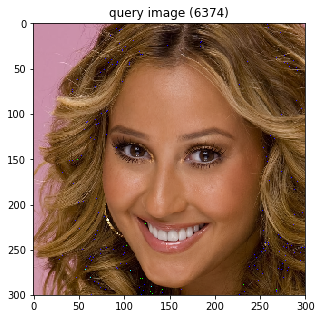

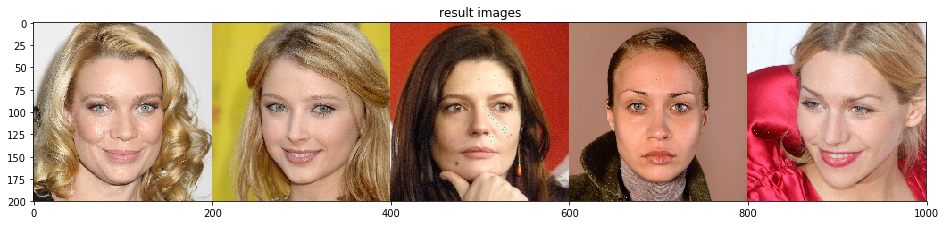

In [7]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")

If we are satisfied with the quality of our image vectors, now would be a good time to save them to disk for later usage. You will need these vectors to run the [next notebook on making an image t-SNE](image-tsne.ipynb).

We need to save both the image features matrix (the PCA-reduced features, not the originals), as well as the array containing the paths to each image, to make sure we can line up the images to their corresponding vectors. 

In [15]:
# not needed anymore pickle.dump([images, pca_features], open('./results/features_caltech101.p', 'wb'))